# Classifying Vascular Networks
Jocelyn Shen

###### In this notebook, I will be using SVMs, PCA, and logistic regression to classify networks

<img src="http://faculty.biomath.ucla.edu/vsavage/Assets/Graphics/dicom_small_9_gd_crop_alpha.png",width=250>

### Animal Networks vs. Plant Networks

The data I am using is from the AngiCAML version of Angicart software.
1. hht_master is data from 18 human head and torso images (ANIMAL)

2. mouselung_master is data from a mouse lung data (ANIMAL)

3. pinon_master is data from a Pinon tree/pine tree (PLANT)

4. ponderosa_master is data from a 5 sapling ponderosa pine trees (PLANT)

5. root_master is data from a large collection of clumps of tree roots (PLANT)  

6. treetips_master is data from a collection of 50cm long tree tip samples (PLANT) 
    
    a) 30 samples -- 5 individuals from 6 different species
    
    b) "class" distinguishes between angiosperm (AS, flowering plant), and gymnosperm (GS, non-flowering plant).

#### STEP 1: Load the Data

In [56]:
from itertools import combinations, chain

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score

%matplotlib inline

plt.style.use("fivethirtyeight")

In [57]:
hht = pd.read_csv("hht_master.csv")
ml = pd.read_csv("mouselung_master.csv")
pinon = pd.read_csv("pinon_master.csv")
ponderosa = pd.read_csv("ponderosa_master.csv")
root = pd.read_csv("root_master.csv")
treetips = pd.read_csv("treetips_master.csv")
datasets = [hht,ml,pinon,ponderosa,root,treetips]

#### STEP 2: Clean the Datasets

##### Human Head and Torso Data

In [58]:
hht_null = hht[hht.isnull().any(axis=1)]
hht = hht.drop(hht_null.index)
hht.head()

,Unnamed: 0,nodeid,parent,indv,generation,n,beta.ave,beta.diff,gamma.ave,gamma.diff
0,1,"(113, 303, 19)-(116, 317, 20)",0,hht01,1.0,2.0,0.878390,-0.052772,0.967488,0.181460
1,2,"(107, 293, 13)-(113, 303, 19)","(113, 303, 19)-(116, 317, 20)",hht01,0.3,2.0,0.321974,-0.025686,0.733451,0.568940
2,3,"(105, 293, 13)-(107, 293, 13)","(107, 293, 13)-(113, 303, 19)",hht01,0.3,2.0,0.704715,0.296466,3.513122,3.013122
3,4,"(104, 292, 13)-(105, 293, 13)","(105, 293, 13)-(107, 293, 13)",hht01,0.2,2.0,1.827236,0.938097,6.745904,5.480993
4,5,"(103, 291, 12)-(104, 292, 13)","(104, 292, 13)-(105, 293, 13)",hht01,0.2,2.0,3.323552,0.572827,12.394017,5.719845


In [59]:
hht_beta_gamma = pd.concat([hht['beta.ave'], hht['beta.diff'], hht['gamma.ave'], hht['gamma.diff']], axis=1, 
                           keys=['beta.ave', 'beta.diff', 'gamma.ave', 'gamma.diff'])
hht_beta_gamma.head()

,beta.ave,beta.diff,gamma.ave,gamma.diff
0,0.878390,-0.052772,0.967488,0.181460
1,0.321974,-0.025686,0.733451,0.568940
2,0.704715,0.296466,3.513122,3.013122
3,1.827236,0.938097,6.745904,5.480993
4,3.323552,0.572827,12.394017,5.719845


##### Mouse Lung Data

In [60]:
ml_null = ml[ml.isnull().any(axis=1)]
ml = ml.drop(ml_null.index)
ml.head()

,Unnamed: 0,nodeid,parent,generation,n,beta.ave,beta.diff,gamma.ave,gamma.diff
0,1,"(156, 101, 104)-(156, 109, 101)",0,0.9,2.0,0.776606,-0.090943,4.343893,1.837972
1,2,"(156, 109, 101)-(159, 131, 98)","(156, 101, 104)-(156, 109, 101)",1.0,2.0,0.551383,-0.008586,0.328757,0.026243
2,3,"(159, 131, 98)-(162, 136, 101)","(156, 109, 101)-(159, 131, 98)",1.0,2.0,1.022952,0.384252,1.305386,0.666746
3,4,"(162, 136, 101)-(164, 137, 112)","(159, 131, 98)-(162, 136, 101)",0.9,2.0,0.485138,0.357218,0.379264,0.296903
4,5,"(164, 137, 112)-(167, 141, 121)","(162, 136, 101)-(164, 137, 112)",0.9,2.0,0.255049,0.103189,0.164871,0.043065


In [61]:
ml_beta_gamma = pd.concat([ml['beta.ave'], ml['beta.diff'], ml['gamma.ave'], ml['gamma.diff']], axis=1, 
                           keys=['beta.ave', 'beta.diff', 'gamma.ave', 'gamma.diff'])
ml_beta_gamma.head()

,beta.ave,beta.diff,gamma.ave,gamma.diff
0,0.776606,-0.090943,4.343893,1.837972
1,0.551383,-0.008586,0.328757,0.026243
2,1.022952,0.384252,1.305386,0.666746
3,0.485138,0.357218,0.379264,0.296903
4,0.255049,0.103189,0.164871,0.043065


##### Pinon Data (Pine Tree Data)

In [62]:
pinon_null = pinon[pinon.isnull().any(axis=1)]
pinon = pinon.drop(pinon_null.index)
pinon.head()

,Unnamed: 0,nodeid,parent,generation,n,beta.ave,beta.diff,gamma.ave,gamma.diff
7,8,10.0,5.0,0.4,2.0,0.356098,0.078049,0.243902,0.158537
9,10,12.0,10.0,0.4,2.0,1.466292,0.511236,1.863636,0.893939
11,12,14.0,12.0,0.3,2.0,1.223529,0.305882,1.296875,0.359375
13,14,16.0,14.0,0.2,2.0,1.429487,0.660256,1.500000,0.733333
15,16,18.0,16.0,0.2,2.0,2.083333,1.250000,2.108696,1.717391


In [63]:
pinon_beta_gamma = pd.concat([pinon['beta.ave'], pinon['beta.diff'], pinon['gamma.ave'], pinon['gamma.diff']], axis=1, 
                           keys=['beta.ave', 'beta.diff', 'gamma.ave', 'gamma.diff'])
pinon_beta_gamma.head()

,beta.ave,beta.diff,gamma.ave,gamma.diff
7,0.356098,0.078049,0.243902,0.158537
9,1.466292,0.511236,1.863636,0.893939
11,1.223529,0.305882,1.296875,0.359375
13,1.429487,0.660256,1.500000,0.733333
15,2.083333,1.250000,2.108696,1.717391


##### Ponderosa Data

In [64]:
ponderosa_null = ponderosa[ponderosa.isnull().any(axis=1)]
ponderosa = ponderosa.drop(ponderosa_null.index)
ponderosa.head()

,Unnamed: 0,nodeid,parent,indv,generation,n,beta.ave,beta.diff,gamma.ave,gamma.diff
0,1,1,0,pond03_edited,1.0,2.0,0.576667,-0.390000,1.014706,0.573529
2,3,3,1,pond03_edited,0.2,2.0,0.544643,-0.133929,0.188889,0.055556
10,11,11,4,pond03_edited,0.5,2.0,0.661538,-0.107692,1.795775,0.950704
11,12,12,9,pond03_edited,0.7,2.0,0.600000,-0.309091,19.958333,10.041667
14,15,15,11,pond03_edited,0.4,2.0,0.650000,-0.200000,0.987500,0.287500


In [65]:
ponderosa_beta_gamma = pd.concat([ponderosa['beta.ave'], ponderosa['beta.diff'], ponderosa['gamma.ave'], ponderosa['gamma.diff']], axis=1, 
                           keys=['beta.ave', 'beta.diff', 'gamma.ave', 'gamma.diff'])
ponderosa_beta_gamma.head()

,beta.ave,beta.diff,gamma.ave,gamma.diff
0,0.576667,-0.390000,1.014706,0.573529
2,0.544643,-0.133929,0.188889,0.055556
10,0.661538,-0.107692,1.795775,0.950704
11,0.600000,-0.309091,19.958333,10.041667
14,0.650000,-0.200000,0.987500,0.287500


##### Root Data

In [66]:
root_null = root[root.isnull().any(axis=1)]
root = root.drop(root_null.index)
root.head()

,Unnamed: 0,nodeid,parent,generation,n,beta.ave,beta.diff,gamma.ave,gamma.diff
0,1,1,0,1,2.0,0.287234,0.053191,0.264423,0.187500
3,4,1,0,1,2.0,0.277778,0.166667,0.134199,0.024892
21,22,1,0,1,2.0,0.550000,0.150000,0.768293,0.378049
30,31,2,1,1,2.0,0.375000,0.025000,0.315574,0.098361
37,38,1,0,1,2.0,0.411765,0.000000,0.194186,0.089535


In [67]:
root_beta_gamma = pd.concat([root['beta.ave'], root['beta.diff'], root['gamma.ave'], root['gamma.diff']], axis=1, 
                           keys=['beta.ave', 'beta.diff', 'gamma.ave', 'gamma.diff'])
root_beta_gamma.head()

,beta.ave,beta.diff,gamma.ave,gamma.diff
0,0.287234,0.053191,0.264423,0.187500
3,0.277778,0.166667,0.134199,0.024892
21,0.550000,0.150000,0.768293,0.378049
30,0.375000,0.025000,0.315574,0.098361
37,0.411765,0.000000,0.194186,0.089535


##### Treetips Data

In [68]:
treetips_null = treetips[treetips.isnull().any(axis=1)]
treetips = treetips.drop(treetips_null.index)
treetips.head()

,Unnamed: 0,class,spcs,id,nodeid,parent,generation,n,beta.ave,beta.diff,gamma.ave,gamma.diff
1,2,GS,dougfir,df737g4,108,96,0.75,2.0,0.658621,-0.231034,0.681818,0.170455
3,4,GS,dougfir,df737g4,110,108,0.25,2.0,0.435484,-0.145161,0.176667,0.116667
7,8,GS,dougfir,df737g4,121,120,0.50,2.0,0.671053,-0.131579,1.550633,0.462025
8,9,GS,dougfir,df737g4,134,120,0.25,2.0,0.530000,-0.070000,0.105556,0.053704
11,12,GS,dougfir,df737g4,37,121,0.50,2.0,0.573770,0.180328,1.011628,0.186047


In [69]:
treetips_beta_gamma = pd.concat([treetips['beta.ave'], treetips['beta.diff'], treetips['gamma.ave'], treetips['gamma.diff']], axis=1, 
                           keys=['beta.ave', 'beta.diff', 'gamma.ave', 'gamma.diff'])
treetips_beta_gamma.head()

,beta.ave,beta.diff,gamma.ave,gamma.diff
1,0.658621,-0.231034,0.681818,0.170455
3,0.435484,-0.145161,0.176667,0.116667
7,0.671053,-0.131579,1.550633,0.462025
8,0.530000,-0.070000,0.105556,0.053704
11,0.573770,0.180328,1.011628,0.186047


#### STEP 3: Combine plant sets and animal sets

Here, I take 15% of the human head and torso, and mouse lung data as my testing dataset

In [70]:
hht_training_size = int(hht_beta_gamma.shape[0]*.85)
ml_training_size = int(ml_beta_gamma.shape[0]*.85)

In [71]:
animals_training = pd.concat([hht_beta_gamma[:hht_training_size], ml_beta_gamma[:ml_training_size]])
animals_training.head()

,beta.ave,beta.diff,gamma.ave,gamma.diff
0,0.878390,-0.052772,0.967488,0.181460
1,0.321974,-0.025686,0.733451,0.568940
2,0.704715,0.296466,3.513122,3.013122
3,1.827236,0.938097,6.745904,5.480993
4,3.323552,0.572827,12.394017,5.719845


In [72]:
animals_testing = pd.concat([hht_beta_gamma[hht_training_size:], ml_beta_gamma[ml_training_size:]])
animals_testing.head()

,beta.ave,beta.diff,gamma.ave,gamma.diff
1607,0.740273,0.060910,1.794760,0.742372
1608,0.898885,0.042851,1.738455,1.577910
1609,1.067210,0.160792,2.570699,0.744976
1615,0.342387,0.005555,0.101684,0.005963
1616,1.168191,0.819315,4.400258,3.852529


In [73]:
pinon_training_size = int(pinon_beta_gamma.shape[0]*.85)
ponderosa_training_size = int(ponderosa_beta_gamma.shape[0]*.85)
root_training_size = int(root_beta_gamma.shape[0]*.85)
treetips_training_size = int(treetips_beta_gamma.shape[0]*.85)
print(pinon_training_size)
print(ponderosa_training_size)
print(root_training_size)
print(treetips_training_size)

427
101
242
262


In [74]:
plants_training = pd.concat([pinon_beta_gamma[:pinon_training_size], 
                             ponderosa_beta_gamma[:ponderosa_training_size], 
                             root_beta_gamma[:root_training_size], 
                             treetips_beta_gamma[:treetips_training_size]])
plants_training.head()

,beta.ave,beta.diff,gamma.ave,gamma.diff
7,0.356098,0.078049,0.243902,0.158537
9,1.466292,0.511236,1.863636,0.893939
11,1.223529,0.305882,1.296875,0.359375
13,1.429487,0.660256,1.500000,0.733333
15,2.083333,1.250000,2.108696,1.717391


In [75]:
plants_testing = pd.concat([pinon_beta_gamma[pinon_training_size:], 
                             ponderosa_beta_gamma[ponderosa_training_size:], 
                             root_beta_gamma[root_training_size:], 
                             treetips_beta_gamma[treetips_training_size:]])
plants_testing.head()

,beta.ave,beta.diff,gamma.ave,gamma.diff
1662,0.153614,-0.021084,0.229508,0.032787
1665,0.163102,0.040107,0.423077,0.076923
1667,0.657895,-0.105263,0.480769,0.173077
1671,0.350365,0.138686,0.500000,0.267442
1674,0.495726,-0.008547,0.230000,0.190000


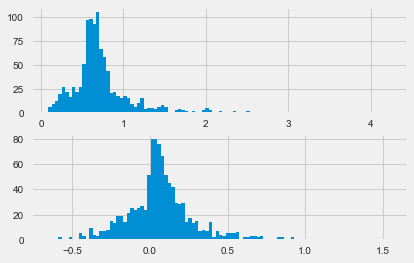

In [76]:
plt.subplot(2,1,1)
plt.hist(plants_training['beta.ave'], bins = 100)
plt.subplot(2,1,2)
plt.hist(plants_training['beta.diff'], bins = 100)
plt.show()

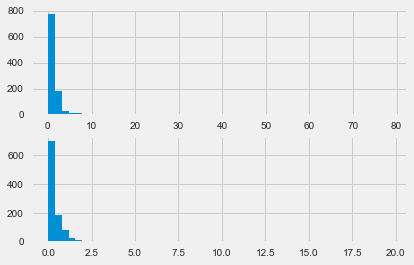

In [77]:
plt.subplot(2,1,1)
plt.hist(plants_training['gamma.ave'], bins = 50)
plt.subplot(2,1,2)
plt.hist(plants_training['gamma.diff'], bins = 50)
plt.show()

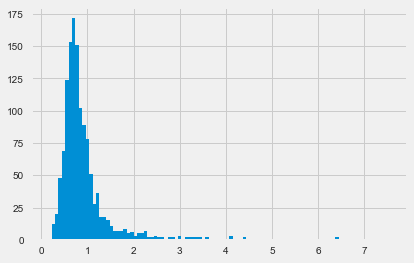

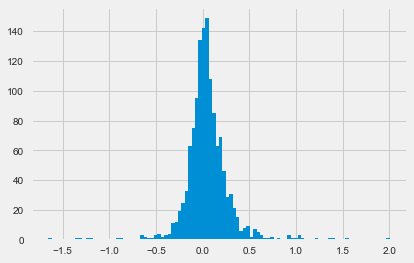

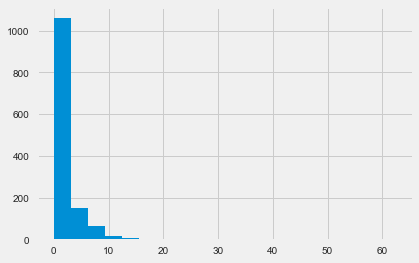

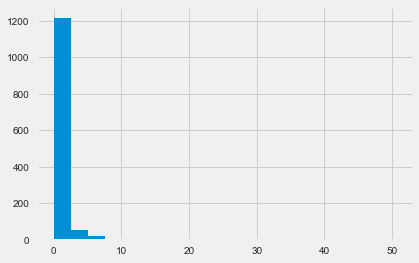

In [78]:
plt.hist(animals_training['beta.ave'], bins = 100)
plt.show()
plt.hist(animals_training['beta.diff'], bins = 100)
plt.show()
plt.hist(animals_training['gamma.ave'], bins = 20)
plt.show()
plt.hist(animals_training['gamma.diff'], bins = 20)
plt.show()

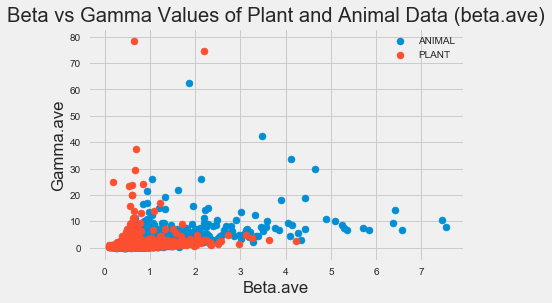

In [79]:
plt.scatter(animals_training['beta.ave'], animals_training['gamma.ave'], label = "ANIMAL")
plt.scatter(plants_training['beta.ave'], plants_training['gamma.ave'], label = "PLANT")
plt.xlabel('Beta.ave')
plt.ylabel('Gamma.ave')
plt.title('Beta vs Gamma Values of Plant and Animal Data (beta.ave)')
plt.legend()
plt.show()

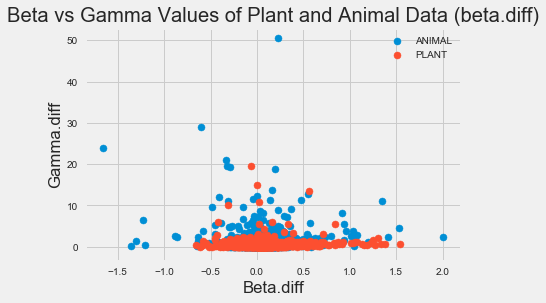

In [80]:
plt.scatter(animals_training['beta.diff'], animals_training['gamma.diff'], label = "ANIMAL")
plt.scatter(plants_training['beta.diff'], plants_training['gamma.diff'], label = "PLANT")
plt.xlabel('Beta.diff')
plt.ylabel('Gamma.diff')
plt.title('Beta vs Gamma Values of Plant and Animal Data (beta.diff)')
plt.legend()
plt.show()

animal: beta.ave vs beta.diff
plant: beta.ave vs beta.diff
animal: gamma.ave vs gamma.diff
plant: gamma.ave vs gamma.diff
all on one

### STEP 4: Support Vector Machines

In [81]:
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.datasets.samples_generator import make_blobs, make_moons, make_circles
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA

In [82]:
def plot_svc_decision_function(model, ax=None):
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

##### 1 for animal, 0 for plant

In [83]:
animals_training["type"] = np.ones(animals_training.shape[0])
animals_training.head()

,beta.ave,beta.diff,gamma.ave,gamma.diff,type
0,0.878390,-0.052772,0.967488,0.181460,1.0
1,0.321974,-0.025686,0.733451,0.568940,1.0
2,0.704715,0.296466,3.513122,3.013122,1.0
3,1.827236,0.938097,6.745904,5.480993,1.0
4,3.323552,0.572827,12.394017,5.719845,1.0


In [84]:
plants_training["type"] = np.ones(plants_training.shape[0])
plants_training.head()

,beta.ave,beta.diff,gamma.ave,gamma.diff,type
7,0.356098,0.078049,0.243902,0.158537,1.0
9,1.466292,0.511236,1.863636,0.893939,1.0
11,1.223529,0.305882,1.296875,0.359375,1.0
13,1.429487,0.660256,1.500000,0.733333,1.0
15,2.083333,1.250000,2.108696,1.717391,1.0


In [85]:
animals_testing["type"] = np.ones(animals_testing.shape[0])
animals_testing.head()

,beta.ave,beta.diff,gamma.ave,gamma.diff,type
1607,0.740273,0.060910,1.794760,0.742372,1.0
1608,0.898885,0.042851,1.738455,1.577910,1.0
1609,1.067210,0.160792,2.570699,0.744976,1.0
1615,0.342387,0.005555,0.101684,0.005963,1.0
1616,1.168191,0.819315,4.400258,3.852529,1.0


In [86]:
plants_testing["type"] = np.zeros(plants_testing.shape[0])
plants_testing.head()

,beta.ave,beta.diff,gamma.ave,gamma.diff,type
1662,0.153614,-0.021084,0.229508,0.032787,0.0
1665,0.163102,0.040107,0.423077,0.076923,0.0
1667,0.657895,-0.105263,0.480769,0.173077,0.0
1671,0.350365,0.138686,0.500000,0.267442,0.0
1674,0.495726,-0.008547,0.230000,0.190000,0.0


In [87]:
training = pd.concat([animals_training, plants_training])
testing = pd.concat([animals_testing, plants_testing])

In [88]:
X = [training['beta.ave'].as_matrix(),training['gamma.ave'].as_matrix()]
X = np.transpose(X)
Y = training['type'].as_matrix()

In [89]:
clf = SVC(kernel='poly', degree = 2)
clf.fit(X, Y)
plt.scatter(X[:, 0], X[:, 1], c=Y, s=10, cmap='inferno')
plot_svc_decision_function(clf)

ValueError: The number of classes has to be greater than one; got 1

In [ ]:
clf

#### STEP 5: Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# Create the plot and add the decision boundary
##   (You are welcome to try and understand what's 
##    going on in this code, but it's not something I 
##    would test you on.)
colorings = {'Iris-setosa':'r', 'Iris-versicolor': 'b', 'Iris-virginica': 'g'}
figure = plt.figure()
ax = figure.add_subplot(1,1,1)
contour = ax.contourf(xx,yy, probs_grid, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = figure.colorbar(contour)
ax_c.set_label("$P(y = 1)$")

# Add your scatter plot!  Use ax.scatter
ax.scatter(iris['Sepal length'],iris['Sepal width'], c=iris['Species'].map(colorings))

plt.show()

In [ ]:
colors = {1:'r', 0:'b'}
plt.scatter(X, Y, c=training["type"].map(colors))
plt.xlabel("beta.ave")
plt.ylabel("gamma.ave")
plt.show()

In [ ]:
y

In [ ]:
#Slice dataframe
X = training[['beta.ave', 'gamma.ave']]
y= training['type']

In [53]:
#Fit the model
logreg = LogisticRegression()
model = logreg.fit(X,y)

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1.0

### STEP 5: Add 3rd Dimension
Scaling exponents from 
conservation based and ratio based methods

compile into functions,
plot colors of the different data sets to see if there is any variance